# Regression CNN models to find initialization values for material parameter extraction

In [1]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns

from models.regression_utils import get_train_val_loaders, load_regression_dataset, denormalize_material_params
from models.Regression_models import PulseParameterNet, ParameterTrainer
from models.utils import identify_device
from torchsummary import summary 

c:\Users\VECSEL\anaconda3\envs\modelling\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device('cuda')

In [3]:
file_path = "regression_data/train_3_layer_30k_nonoise_n1to6_max_d_250micron.pt"
#file_path = "regression_data/train_3_layer_512_nonoise_n1to8.pt"

# Configuration
param_ranges = {
    'n': (1.0, 6.0),
    'k': (-0.1, 0.001),
    'd': (0.05e-3, 0.25e-3)
    }

dataset = load_regression_dataset(file_path)

train_loader, val_loader, num_samples = get_train_val_loaders(
    dataset_path=file_path,
    batch_size=128,
    val_split=0.1
)


print(f"Training batches: {len(train_loader)}")
print(f"Validation batches: {len(val_loader)}")

Loading data from regression_data/train_3_layer_30k_nonoise_n1to6_max_d_250micron.pt
Dataset loaded successfully!
Number of samples: 30000
Shape of input pulse: torch.Size([1, 1024]), target vector: torch.Size([9])
Loading data from regression_data/train_3_layer_30k_nonoise_n1to6_max_d_250micron.pt
Dataset loaded successfully!
Number of samples: 30000
Shape of input pulse: torch.Size([1, 1024]), target vector: torch.Size([9])
Training batches: 211
Validation batches: 24


In [4]:
model = PulseParameterNet(input_length=1024)
trainer = ParameterTrainer(model, param_ranges)

# Display model info
total_params = sum(p.numel() for p in model.parameters())
print(f"\nModel initialized:")
print(f"Total parameters: {total_params:,}")
print(f"Input pulse length: {1024}")
print(f"Device: {trainer.device}")


Model initialized:
Total parameters: 456,585
Input pulse length: 1024
Device: cuda


In [5]:
summary(model, input_size=(1,1024))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1              [-1, 32, 512]             512
       BatchNorm1d-2              [-1, 32, 512]              64
              ReLU-3              [-1, 32, 512]               0
            Conv1d-4              [-1, 64, 256]          18,496
       BatchNorm1d-5              [-1, 64, 256]             128
              ReLU-6              [-1, 64, 256]               0
            Conv1d-7             [-1, 128, 128]          41,088
       BatchNorm1d-8             [-1, 128, 128]             256
              ReLU-9             [-1, 128, 128]               0
           Conv1d-10              [-1, 256, 64]          98,560
      BatchNorm1d-11              [-1, 256, 64]             512
             ReLU-12              [-1, 256, 64]               0
AdaptiveAvgPool1d-13               [-1, 256, 1]               0
           Linear-14                  [

In [6]:
num_epochs = 100
lr = 0.001

# Train model
print(f"\nStarting training for {num_epochs} epochs...")
final_metrics = trainer.train(train_loader, val_loader, 
                                num_epochs=num_epochs, lr=lr,
                                experiment_name=None)


Starting training for 100 epochs...
Starting training: pulse_param_net_20250820_162016
Model parameters: 456,585
Device: cuda


Training Progress:   1%|          | 1/100 [00:01<01:57,  1.19s/it, Train Loss=0.073628, Val Loss=0.165108, Val R²=-1.0145, Tolerance=0.189]

Epoch   0: Train Loss=0.073628, Val Loss=0.165108, Val R²=-1.0145, Avg Tolerance=0.1887


Training Progress:  11%|█         | 11/100 [00:12<01:38,  1.10s/it, Train Loss=0.048261, Val Loss=0.285132, Val R²=-2.4461, Tolerance=0.090]

Epoch  10: Train Loss=0.048261, Val Loss=0.285132, Val R²=-2.4461, Avg Tolerance=0.0897


Training Progress:  21%|██        | 21/100 [00:23<01:26,  1.10s/it, Train Loss=0.044061, Val Loss=0.359804, Val R²=-3.3446, Tolerance=0.052] 

Epoch  20: Train Loss=0.044061, Val Loss=0.359804, Val R²=-3.3446, Avg Tolerance=0.0519


Training Progress:  31%|███       | 31/100 [00:34<01:16,  1.11s/it, Train Loss=0.040621, Val Loss=0.179790, Val R²=-1.1688, Tolerance=0.115]

Epoch  30: Train Loss=0.040621, Val Loss=0.179790, Val R²=-1.1688, Avg Tolerance=0.1154


Training Progress:  41%|████      | 41/100 [00:45<01:05,  1.10s/it, Train Loss=0.039515, Val Loss=0.287701, Val R²=-2.4691, Tolerance=0.155]

Epoch  40: Train Loss=0.039515, Val Loss=0.287701, Val R²=-2.4691, Avg Tolerance=0.1550


Training Progress:  51%|█████     | 51/100 [00:56<00:54,  1.11s/it, Train Loss=0.037782, Val Loss=0.056412, Val R²=0.3204, Tolerance=0.266] 

Epoch  50: Train Loss=0.037782, Val Loss=0.056412, Val R²=0.3204, Avg Tolerance=0.2663


Training Progress:  61%|██████    | 61/100 [01:07<00:43,  1.12s/it, Train Loss=0.036829, Val Loss=0.044721, Val R²=0.4589, Tolerance=0.317]

Epoch  60: Train Loss=0.036829, Val Loss=0.044721, Val R²=0.4589, Avg Tolerance=0.3166


Training Progress:  71%|███████   | 71/100 [01:18<00:32,  1.11s/it, Train Loss=0.036382, Val Loss=0.044647, Val R²=0.4600, Tolerance=0.304]

Epoch  70: Train Loss=0.036382, Val Loss=0.044647, Val R²=0.4600, Avg Tolerance=0.3037


Training Progress:  81%|████████  | 81/100 [01:29<00:21,  1.11s/it, Train Loss=0.035648, Val Loss=0.048672, Val R²=0.4127, Tolerance=0.302]

Epoch  80: Train Loss=0.035648, Val Loss=0.048672, Val R²=0.4127, Avg Tolerance=0.3017


Training Progress:  91%|█████████ | 91/100 [01:41<00:10,  1.12s/it, Train Loss=0.035429, Val Loss=0.038769, Val R²=0.5310, Tolerance=0.330]

Epoch  90: Train Loss=0.035429, Val Loss=0.038769, Val R²=0.5310, Avg Tolerance=0.3302


Training Progress: 100%|██████████| 100/100 [01:51<00:00,  1.11s/it, Train Loss=0.035129, Val Loss=0.037350, Val R²=0.5483, Tolerance=0.337]



Running final evaluation...



FINAL RESULTS
Overall R²: 0.5483
Overall RMSE: 0.500148
Overall MAE: 0.215942
Average Tolerance Satisfaction: 0.3370

Per-parameter results:
Parameter    R²       RMSE         MAE          Within Tol   Target Tol  
--------------------------------------------------------------------------------
n1           0.4787   1.022882     0.829057     0.072        0.100000    
k1           0.3983   0.022505     0.018282     0.025        0.001000    
d1           0.4335   0.000043     0.000035     0.738        0.000050    
n2           0.9290   0.373686     0.227815     0.347        0.100000    
k2           0.5821   0.018999     0.014613     0.050        0.001000    
d2           0.8138   0.000025     0.000018     0.946        0.000050    
n3           0.4646   1.031507     0.835002     0.075        0.100000    
k3           0.3768   0.023008     0.018620     0.038        0.001000    
d3           0.4578   0.000043     0.000035     0.743        0.000050    


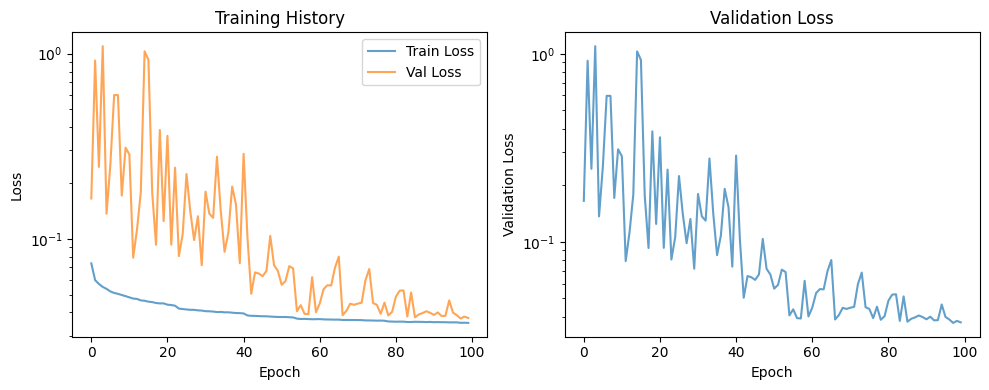

In [7]:
# Print final results
print("\n" + "="*80)
print("FINAL RESULTS")
print("="*80)
print(f"Overall R²: {final_metrics['overall']['r2']:.4f}")
print(f"Overall RMSE: {final_metrics['overall']['rmse']:.6f}")
print(f"Overall MAE: {final_metrics['overall']['mae']:.6f}")
print(f"Average Tolerance Satisfaction: {final_metrics['avg_tolerance_satisfaction']:.4f}")

print("\nPer-parameter results:")
print(f"{'Parameter':<12} {'R²':<8} {'RMSE':<12} {'MAE':<12} {'Within Tol':<12} {'Target Tol':<12}")
print("-" * 80)

for param, metrics in final_metrics['parameters'].items():
    print(f"{param:<12} {metrics['r2']:<8.4f} {metrics['rmse']:<12.6f} "
            f"{metrics['mae']:<12.6f} {metrics['within_tolerance']:<12.3f} "
            f"{metrics['tolerance']:<12.6f}")

# Plot training history
trainer.plot_training_history()

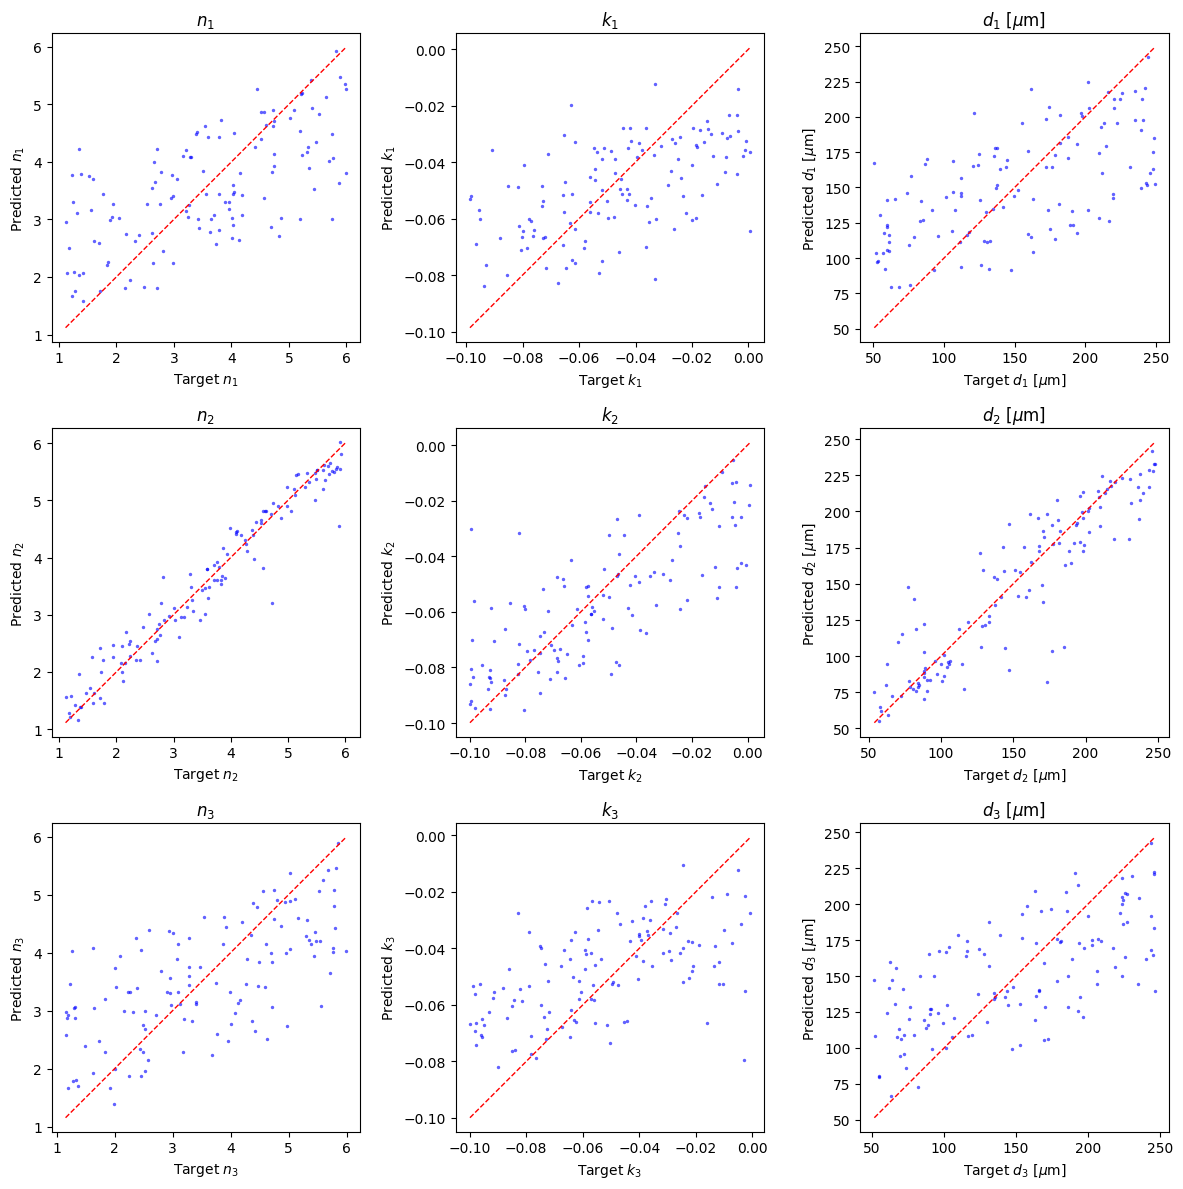

In [8]:
model.eval()

all_predictions = []
all_targets = []


with torch.no_grad():
    for pulses, params in val_loader:
        pulses = pulses.to(device)
        params = params.to(device)
        
        predictions = model(pulses)
        all_predictions.append(predictions.cpu())
        all_targets.append(params.cpu())

# Parameter labels and types
param_labels = [
    r"$n_1$", r"$k_1$", r"$d_1$ [$\mu$m]",
    r"$n_2$", r"$k_2$", r"$d_2$ [$\mu$m]",
    r"$n_3$", r"$k_3$", r"$d_3$ [$\mu$m]"
]

thickness_indices = [2, 5, 8]  # positions of d1, d2, d3

preds_plot = denormalize_material_params(all_predictions[0].clone())
targets_plot = denormalize_material_params(all_targets[0].clone())

preds_plot[:, thickness_indices] *= 1e6
targets_plot[:, thickness_indices] *= 1e6

# Create figure
fig, axes = plt.subplots(3, 3, figsize=(12, 12))
axes = axes.flatten()

for i in range(9):
    ax = axes[i]
    sns.scatterplot(
        x=targets_plot[:, i],
        y=preds_plot[:, i],
        ax=ax,
        s=5, color='blue', alpha=0.6, edgecolor=None
    )

    # Add 45° perfect prediction line
    min_val = min(targets_plot[:, i].min(), preds_plot[:, i].min())
    max_val = max(targets_plot[:, i].max(), preds_plot[:, i].max())
    ax.plot([min_val, max_val], [min_val, max_val], 'r--', lw=1)

    ax.set_xlabel(f"Target {param_labels[i]}")
    ax.set_ylabel(f"Predicted {param_labels[i]}")
    ax.set_title(param_labels[i])
    ax.set_aspect('equal', adjustable='box')

plt.tight_layout()
plt.show()